In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import requests

In [ ]:
"""
Prereqs:
    - Download Snapshot vote reports either manually or using snapshot_report_download.py script
    - Download the token's hodler distribution from Etherscan:
        - for INDEX token, Download CSV link at https://etherscan.io/token/0x0954906da0Bf32d5479e25f46056d22f08464cab#balances
        - this could not be automated as Etherscan requires recaptcha. Could be automated with a graph or etherscan pro API call
"""

In [56]:
# Parameters: Substitute with the values of the project and Snapshot vote you want to analyze
# Running analsysis for all Index Coop Decision Gate 2 votes
vote_urls = {
    'BTC2X-FLI': 'https://snapshot.org/#/index/proposal/Qmc2DPHoKnyYxRjQfwbpbBngt5xHZrLBgkywGqZm7hHnEU',
    'SMI': 'https://snapshot.org/#/index/proposal/QmYBG5zerdSkC9TGwguy5biCS5h2cg49PQCHCukJqHmfE1',
    'TTI': 'https://snapshot.org/#/index/proposal/QmTPVkgfJBB1go2DCFhmacjgSWrLUzTFimdTGdB7d9Q2ao',
    'MVI': 'https://snapshot.org/#/index/proposal/QmadsabYMJC96jU2S2kPCSh1suVfDVApGLwrux2WwsHd7x',
    'FLI2': 'https://snapshot.org/#/index/proposal/QmYHV2vdTaSubtNJefSoYx82ypsmtzrT7CGUU1EHsXzHC3',
    'FLI1': 'https://snapshot.org/#/index/proposal/QmQwQn4k324kMKPjsSX6ZEzjkkKWh1DNfAN2mQ3dd5aP1a'
}
proposal_ids = [url.split('/')[-1] for url in vote_urls.values()]
local_download_folder_path = 'C:/Users/craig/Downloads/'
etherscan_token_hodler_csv_path = 'etherscan_index_hodler_table.csv'

# Remove treasury, vesting and DEX LP wallets. Manually entered from https://etherscan.io/token/0x0954906da0Bf32d5479e25f46056d22f08464cab#balances
wallet_addresses_to_exclude = [
    '0xd89c642e52bd9c72bcc0778bcf4de307cc48e75a',
    '0xf64d061106054fe63b0aca68916266182e77e9bc',
    '0x26e316f5b3819264df013ccf47989fb8c891b088',
    '0x9467cfadc9de245010df95ec6a585a506a8ad5fc',
    '0xe2250424378b6a6dc912f5714cfd308a8d593986',
    '0x71f2b246f270c6af49e2e514ca9f362b491fbbe1',
    '0x4c11dfd35a4fe079b41d5d9729ed34c00d487712',
    '0x66a7d781828b03ee1ae678cd3fe2d595ba3b6000',
    '0x0d627ca04a97219f182dab0dc2a23fb4a5b02a9d',
    '0x5c29aa6761803bcfda7f683eaa0ff9bddda3649d',
    '0xce3c6312385fcf233ab0de574b0cb1a588566c3f',
    '0xb93b505ed567982e2b6756177ddd23ab5745f309',
    '0xdd111f0fc07f4d89ed6ff96dbab19a61450b8435',
    '0x0f58793e8cf39d6b60919ffaf773a7f95a568146',
    '0xa73df646512c82550c2b3c0324c4eedee53b400c',
    '0xcf19a7c81fcf0e01c927f28a2b551405e58c77e5',
    '0x3452a7f30a712e415a0674c0341d44ee9d9786f9',
    '0x674bdf20a0f284d710bc40872100128e2d66bd3f',
    '0x8f06fba4684b5e0988f215a47775bb611af0f986'
]

# Enter the quorum threshold for the project
coin_gecko_response = requests.get('https://api.coingecko.com/api/v3/coins/index-cooperative?tickers=true&market_data=true').json()
circulating_supply = coin_gecko_response['market_data']['circulating_supply']
quorum_threshold = 0.15
yes_vote_threshold = 0.6
votes_needed_for_quorum = round(project_quorum_threshold * circulating_supply, 2)
etherscan_token_hodler_csv_path = 'etherscan_index_hodler_table.csv'

In [3]:
def compute_gini(series_label:str, series_np_array:np.array):
    gini = qe.gini_coefficient(series_np_array)
    print(f'{series_label} Gini Coefficient: {gini}')
    print(f'Global Wealth Gini Coefficient (2019): 0.885, source: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_inequality')

    # Plot Lorenz curve
    equality_curve, lorenz_curve = qe.lorenz_curve(series_np_array)
    fig, ax = plt.subplots()
    ax.plot(equality_curve, lorenz_curve, label=f'Lorenz curve of {series_label}')
    ax.plot(equality_curve, equality_curve, label='Lorenz curve, equality')
    ax.legend()
    plt.show()

The minimum number of (all) hodlers needed to pass an initiative is: 2
All INDEX wallet balances Gini Coefficient: 0.9421134147542752
Global Wealth Gini Coefficient (2019): 0.885, source: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_inequality


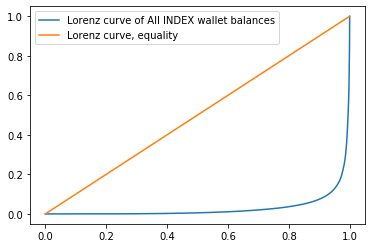

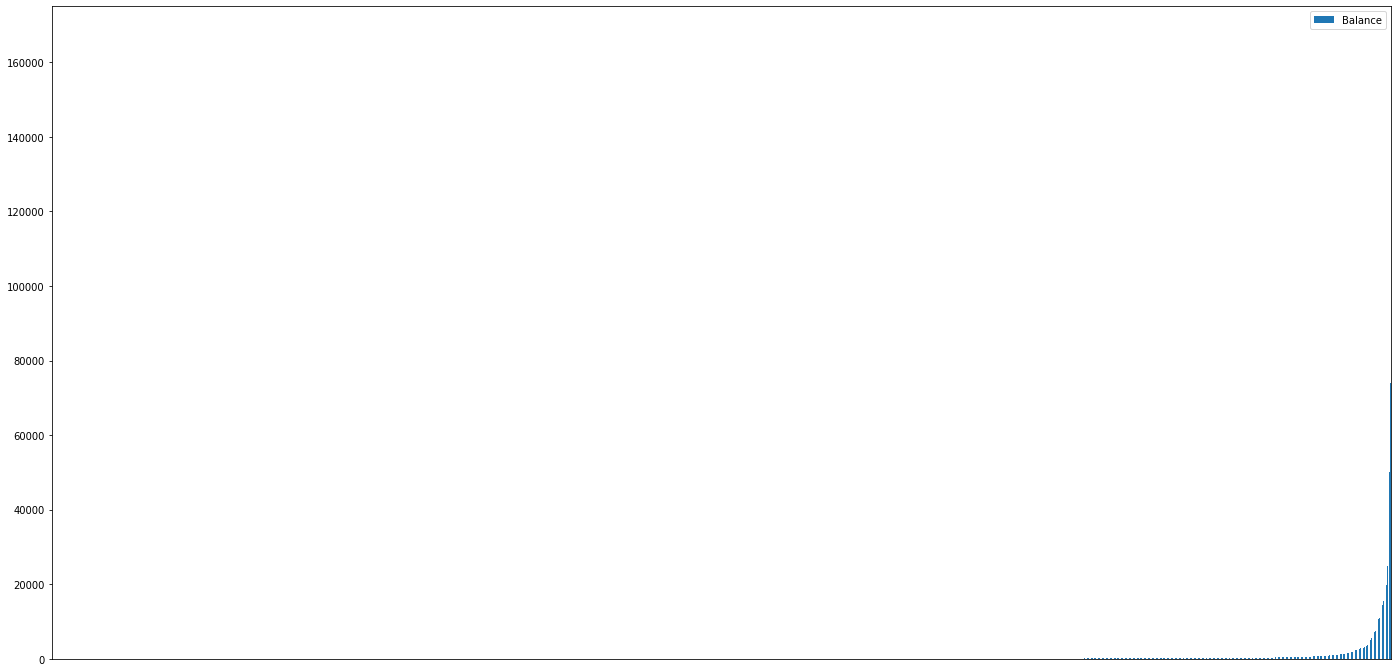

In [9]:
# Read Etherscan.io hodler wallet balance csv file
index_hodlers_with_treasury = pd.read_csv(etherscan_token_hodler_csv_path)
index_hodler_df = index_hodlers_with_treasury.loc[~index_hodlers_with_treasury.HolderAddress.isin(wallet_addresses_to_exclude)]
index_hodler_df = index_hodler_df.sort_values('Balance', ascending=False)
index_hodler_df['cumulative_dist'] = index_hodler_df['Balance'].cumsum()
index_hodler_df.index = range(len(index_hodler_df))
index_hodler_df.Balance.describe()
theoretical_minimum_number_of_voters_needed = min(index_hodler_df.index[index_hodler_df['cumulative_dist'] > votes_needed_for_quorum]) + 1
print(f'The minimum number of (all) hodlers needed to pass an initiative is: {theoretical_minimum_number_of_voters_needed}')
hodler_balance_array = index_hodler_df['Balance'].to_numpy()
compute_gini('All INDEX wallet balances', hodler_balance_array)
index_hodler_df.sort_values('Balance').plot.bar(y='Balance', figsize=(24,12)).xaxis.set_visible(False)

In [57]:
def run_vote_analysis(vote_url:str):
    proposal_id = vote_url.split('/')[-1]
    vote_df = pd.read_csv(f'{local_download_folder_path}snapshot-report-{proposal_id}.csv')
    vote_df = vote_df.sort_values('balance', ascending=False)
    vote_df['cumulative_dist'] = vote_df['balance'].cumsum()
    vote_df.index = range(len(vote_df))
    votes_for = round(vote_df.loc[vote_df['choice'] == 1, 'balance'].sum(), 2)
    voters_for = round(vote_df.loc[vote_df['choice'] == 1, 'choice'].sum(), 2)
    votes_against = round(vote_df.loc[vote_df['choice'] == 2, 'balance'].sum(), 2)
    voters_against = len(vote_df.loc[vote_df['choice'] == 2, 'choice'])
    print(f'Votes for: {votes_for}, Votes against: {votes_against}')
    print(f'Unique voters (wallets) for: {voters_for}, Unique voters (wallets) against: {voters_against}')
    print(f'Did the vote exceed the threshold? {"Yes" if votes_for > votes_needed_for_quorum else "No"}')
    if votes_for > votes_needed_for_quorum and votes_for/(votes_for + votes_against) > 0.6:
        print(f'This initiative succeeded. {votes_for} votes in favor > {votes_needed_for_quorum} votes needed to meet quorum')
        minimum_number_of_voters_needed = min(vote_df.index[vote_df['cumulative_dist'] > votes_needed_to_pass]) + 1
        print(f'The minimum number of voting hodlers needed to pass this initiative was: {minimum_number_of_voters_needed}')
    else:
        print(f'This initiative failed. {votes_for} votes in favor < {votes_needed_for_quorum} votes needed to meet quorum')
        votes_short_by = round(votes_needed_for_quorum - votes_for, 2)
        print(f'The minimum number of additional votes needed to pass was {votes_short_by}')
        if index_hodler_df['Balance'].max() > votes_short_by:
            lowest_rank_balance_needed_to_pass =  min(index_hodler_df.index[index_hodler_df['Balance'] > votes_short_by]) + 1
            print(f'This means the initiative could have passed if any wallet with balance ranked in the top {lowest_rank_balance_needed_to_pass} had voted')
    voter_balance_array = vote_df['balance'].to_numpy()
    compute_gini('All INDEX voter balances', voter_balance_array)
    vote_df.plot.bar(y='balance', figsize=(24,8)).xaxis.set_visible(False)
    if votes_for > votes_needed_for_quorum:
        quorum_threshold_index = min(vote_df.index[vote_df['cumulative_dist'] > votes_needed_to_pass])
        plt.axvline(x=quorum_threshold_index, color='red')

Votes for: 344272.58, Votes against: 0.0
Unique voters (wallets) for: 123, Unique voters (wallets) against: 0
Did the vote exceed the threshold? Yes
This initiative succeeded. 344272.58 votes in favor > 212670.51 votes needed to meet quorum
The minimum number of voting hodlers needed to pass this initiative was: 4
All INDEX voter balances Gini Coefficient: 0.899783364889563
Global Wealth Gini Coefficient (2019): 0.885, source: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_inequality


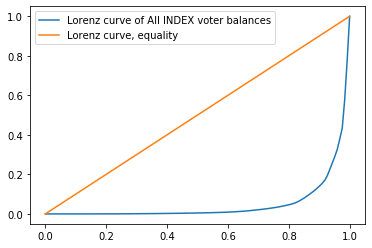

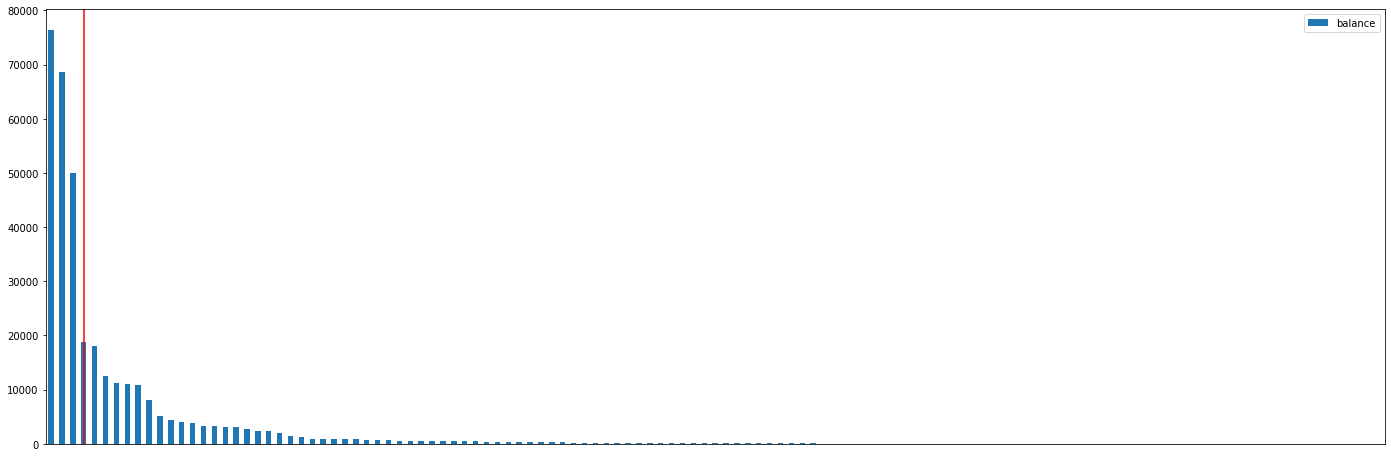

In [58]:
run_vote_analysis(vote_urls['BTC2X-FLI'])

Votes for: 262434.99, Votes against: 0.0
Unique voters (wallets) for: 149, Unique voters (wallets) against: 0
Did the vote exceed the threshold? Yes
This initiative succeeded. 262434.99 votes in favor > 212670.51 votes needed to meet quorum
The minimum number of voting hodlers needed to pass this initiative was: 14
All INDEX voter balances Gini Coefficient: 0.8882854586745768
Global Wealth Gini Coefficient (2019): 0.885, source: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_inequality


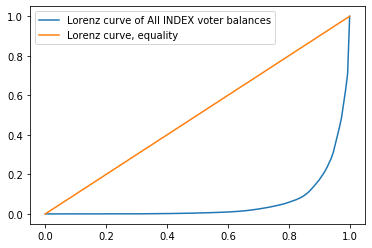

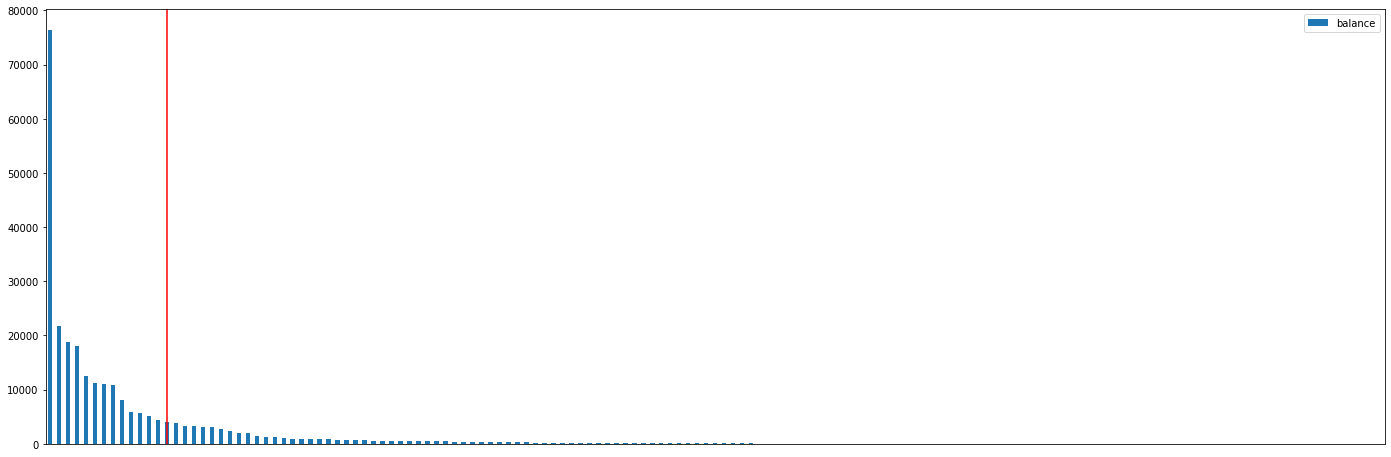

In [59]:
run_vote_analysis(vote_urls['SMI'])

Votes for: 42334.52, Votes against: 2721.16
Unique voters (wallets) for: 115, Unique voters (wallets) against: 4
Did the vote exceed the threshold? No
This initiative failed. 42334.52 votes in favor < 212670.51 votes needed to meet quorum
The minimum number of additional votes needed to pass was 170335.99
All INDEX voter balances Gini Coefficient: 0.8058077711130683
Global Wealth Gini Coefficient (2019): 0.885, source: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_inequality


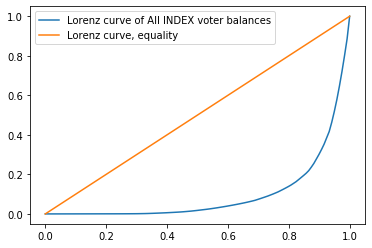

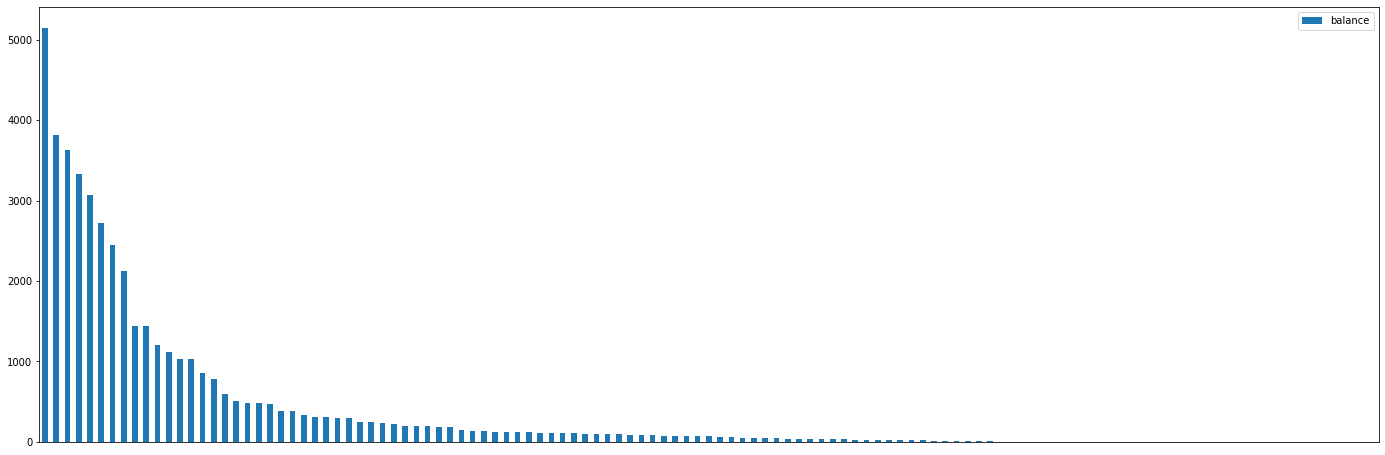

In [60]:
run_vote_analysis(vote_urls['TTI'])

Votes for: 246119.08, Votes against: 0.0
Unique voters (wallets) for: 153, Unique voters (wallets) against: 0
Did the vote exceed the threshold? Yes
This initiative succeeded. 246119.08 votes in favor > 212670.51 votes needed to meet quorum
The minimum number of voting hodlers needed to pass this initiative was: 19
All INDEX voter balances Gini Coefficient: 0.8835600874784805
Global Wealth Gini Coefficient (2019): 0.885, source: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_inequality


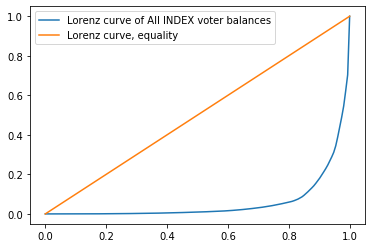

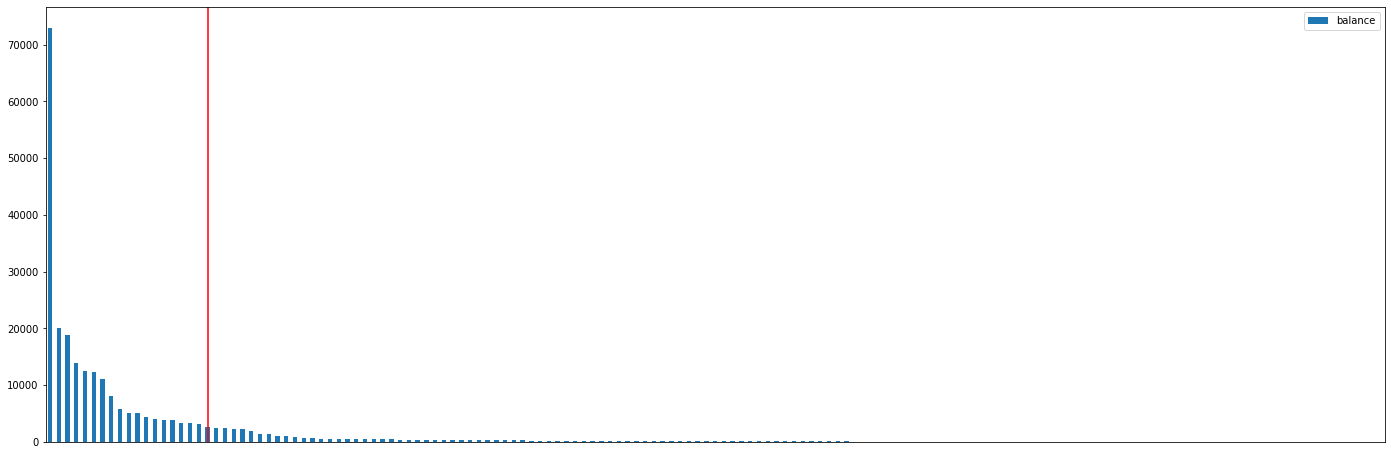

In [61]:
run_vote_analysis(vote_urls['MVI'])

Votes for: 323936.34, Votes against: 321.19
Unique voters (wallets) for: 115, Unique voters (wallets) against: 1
Did the vote exceed the threshold? Yes
This initiative succeeded. 323936.34 votes in favor > 212670.51 votes needed to meet quorum
The minimum number of voting hodlers needed to pass this initiative was: 5
All INDEX voter balances Gini Coefficient: 0.9014330237828367
Global Wealth Gini Coefficient (2019): 0.885, source: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_inequality


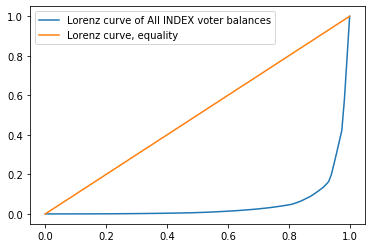

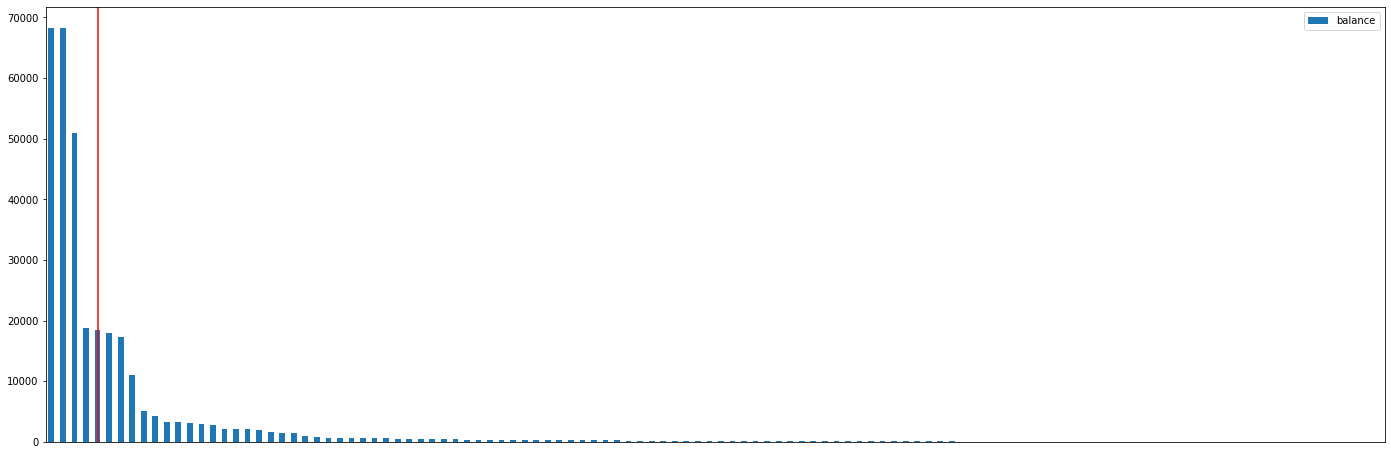

In [62]:
run_vote_analysis(vote_urls['FLI2'])

Votes for: 75532.24, Votes against: 0.0
Unique voters (wallets) for: 70, Unique voters (wallets) against: 0
Did the vote exceed the threshold? No
This initiative failed. 75532.24 votes in favor < 212670.51 votes needed to meet quorum
The minimum number of additional votes needed to pass was 137138.27
This means the initiative could have passed if any wallet with balance ranked in the top 1 had voted
All INDEX voter balances Gini Coefficient: 0.8431664106381022
Global Wealth Gini Coefficient (2019): 0.885, source: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_inequality


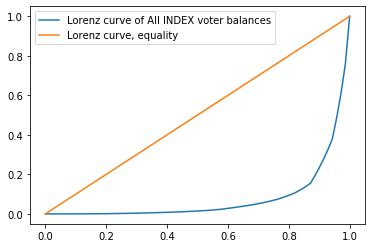

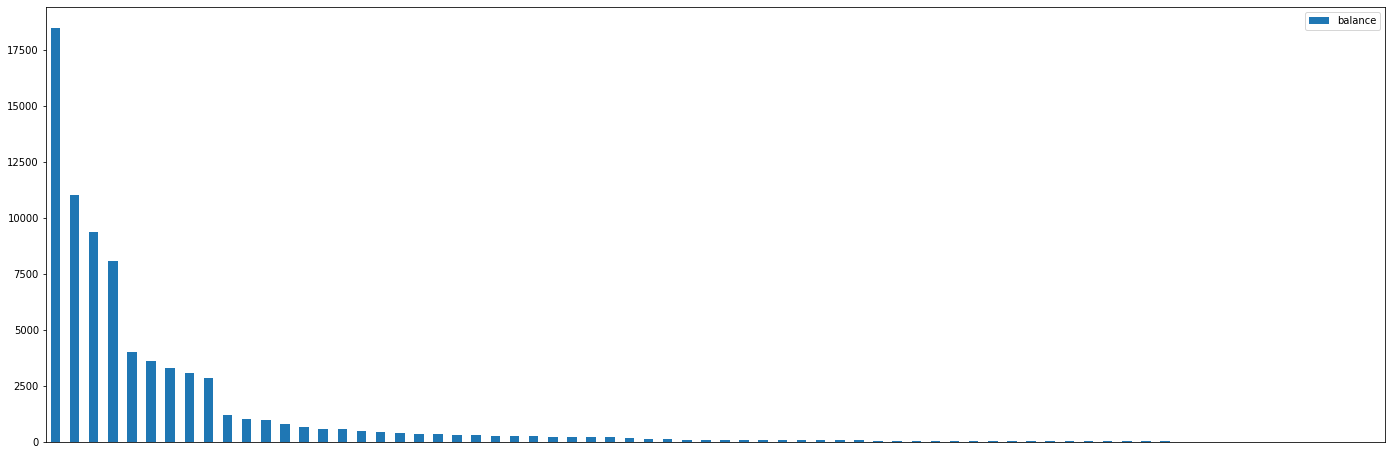

In [63]:
run_vote_analysis(vote_urls['FLI1'])